In [ ]:
import intake
from easygems import healpix as egh

import matplotlib.pyplot as plt
import numpy as np

import warnings

warnings.filterwarnings("ignore", category=FutureWarning) # don't warn us about future package conflicts

In [ ]:
import cmocean

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
import xarray as xr

In [25]:
loc_um_1H_z7 = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z7.zarr/" #PT1H is hourly data
loc_um_3H_z7 = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT3H.z7.zarr/" #PT1H is hourly data
loc_icon_daily_z7 = "/g/data/qx55/germany_node/d3hp003.zarr/P1D_mean_z7_atm.zarr/" #PT1H is hourly data
loc_icon_3H_z7 = "/g/data/qx55/germany_node/d3hp003.zarr/P1D_mean_z10_atm.zarr//" #PT1H is hourly data

um_data = xr.open_zarr(loc_um_1H_z7)
um_data_3d = xr.open_zarr(loc_um_3H_z7)
icon_data = xr.open_zarr(loc_icon_daily_z7)
icon_data_3d = xr.open_zarr(loc_icon_3H_z7)

In [26]:
from dask.diagnostics import ProgressBar

In [49]:
with ProgressBar():
    icon_daily_loaded = (icon_data.pr*86400).sel(time = slice('2020-03-01', '2021-03-01')).load()
# egh.healpix_show(icon_daily_z5.pr.mean('time'), cmap=cmocean.cm.deep)

[########################################] | 100% Completed | 1.36 sms


In [50]:
with ProgressBar():
    icon_clt_daily_loaded = (icon_data.clt).load()
# egh.healpix_show(icon_daily_z5.pr.mean('time'), cmap=cmocean.cm.deep)

In [51]:
with ProgressBar():
    icon_rlut_daily_loaded = (icon_data.rlut.sel(time = slice('2020-03-01', '2021-03-01')).coarsen(time = 24, boundary='trim').mean('time')).load()
    icon_rsut_daily_loaded = (icon_data.rsut.sel(time = slice('2020-03-01', '2021-03-01')).coarsen(time = 24, boundary='trim').mean('time')).load()

[########################################] | 100% Completed | 1.14 sms
[########################################] | 100% Completed | 1.22 sms


In [52]:
with ProgressBar():
    um_daily_loaded = (um_data.pr.sel(time = slice('2020-03-01', '2021-03-01')).coarsen(time=24, boundary='trim').mean('time')*86400).load()
# egh.healpix_show(um_z5_t1h.pr.coarsen(time=24, boundary='trim').mean('time').mean('time'), cmap=cmocean.cm.deep)

[########################################] | 100% Completed | 11.36 s


In [53]:
with ProgressBar():
    um_clt_daily_loaded = (um_data.clt.sel(time = slice('2020-03-01', '2021-03-01')).coarsen(time = 24, boundary='trim').mean('time')).load()

[########################################] | 100% Completed | 13.00 s


In [54]:
with ProgressBar():
    um_llcw_daily_loaded = (um_data_3d.clw.sel(pressure=slice(850, 950)).mean('pressure').sel(time = slice('2020-03-01', '2021-03-01')).coarsen(time = 8, boundary='trim').mean('time')).load()
# egh.healpix_show(icon_daily_z5.pr.mean('time'), cmap=cmocean.cm.deep)

[########################################] | 100% Completed | 13.36 s


In [55]:
with ProgressBar():
    um_rlut_daily_loaded = (um_data.rlut.sel(time = slice('2020-03-01', '2021-03-01')).coarsen(time = 24, boundary='trim').mean('time')).load()
    um_rsut_daily_loaded = (um_data.rsut.sel(time = slice('2020-03-01', '2021-03-01')).coarsen(time = 24, boundary='trim').mean('time')).load()

[########################################] | 100% Completed | 16.21 s
[########################################] | 100% Completed | 13.49 s


In [ ]:
def plot_data(data, cmap=cmocean.cm.deep, vmin=0, vmax=10, cbar_extend='both', aspect=45, cbar_orientation='horizontal', cbar_shrink=1.0,  plot_title='ICON model', cbar_label='Precip (mm/day)'):
    projection = ccrs.Robinson(central_longitude=160)
    ax = egh.create_geoaxis(add_coastlines=True, projection=projection)
    im = egh.healpix_show(data.values, cmap=cmap, vmin=vmin, vmax=vmax, add_coastlines=True, ax=ax)
    gl = ax.gridlines(alpha=0., draw_labels=True)
    gl.right_labels=False
    gl.top_labels=False
    ax.set_title(plot_title)
    # fig = ax.get_figure()
    plt.colorbar(im, orientation=cbar_orientation, extend=cbar_extend, aspect=aspect, shrink=cbar_shrink, label=cbar_label)

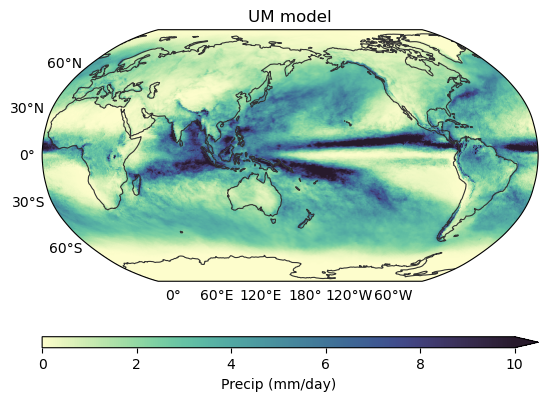

In [57]:
plot_data(um_daily_loaded.mean('time'), plot_title='UM model', cbar_extend='max')

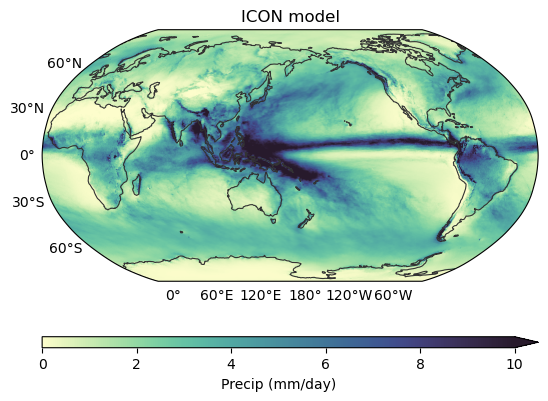

In [58]:
plot_data(icon_daily_loaded.mean('time'), plot_title='ICON model', cbar_extend='max')

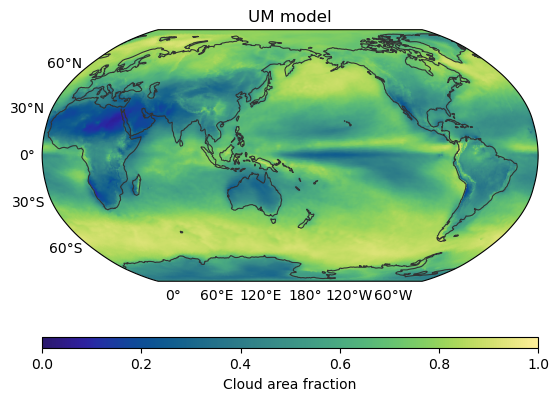

In [59]:
plot_data(um_clt_daily_loaded.mean('time'), cmap=cmocean.cm.haline, vmin=0, vmax=1, cbar_extend='neither', aspect=45, cbar_orientation='horizontal', cbar_shrink=1.0,  plot_title='UM model', cbar_label='Cloud area fraction')

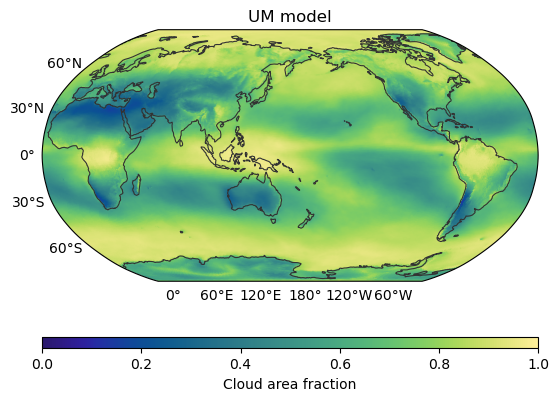

In [60]:
plot_data(icon_clt_daily_loaded.mean('time'), cmap=cmocean.cm.haline, vmin=0, vmax=1, cbar_extend='neither', aspect=45, cbar_orientation='horizontal', cbar_shrink=1.0,  plot_title='UM model', cbar_label='Cloud area fraction')

In [ ]:
import numpy as np

In [62]:
um_clt_monthly = um_clt_daily_loaded.resample(time = '1M').mean('time')
um_pr_monthly = um_daily_loaded.resample(time = '1M').mean('time')

icon_clt_monthly = icon_clt_daily_loaded.resample(time = '1M').mean('time')
icon_pr_monthly = icon_daily_loaded.resample(time = '1M').mean('time')

In [90]:
um_strat_regime = xr.where((um_clt_monthly.mean('time') > 0.70) & (um_pr_monthly.mean('time') < 1.0), 1, 0)

um_mod_conv_regime = xr.where((um_clt_monthly.mean('time') < 0.7) & (um_pr_monthly.mean('time') > 1.5) & (um_pr_monthly.mean('time') < 6), 0.1, 0)

um_strong_conv_regime = xr.where(um_pr_monthly.mean('time') > 8, -1, 0)

um_regimes = um_strat_regime + um_mod_conv_regime + um_strong_conv_regime
um_regimes = xr.where(um_regimes == 0, np.nan, um_regimes)

In [91]:
icon_strat_regime = xr.where((icon_clt_monthly.mean('time') > 0.70) & (icon_pr_monthly.mean('time') < 1.0), 1, 0)

icon_mod_conv_regime = xr.where((icon_clt_monthly.mean('time') < 0.7) & (icon_pr_monthly.mean('time') > 1.5) & (icon_pr_monthly.mean('time') < 6), 0.1, 0)

icon_strong_conv_regime = xr.where(icon_pr_monthly.mean('time') > 8, -1, 0)

icon_regimes = icon_strat_regime + icon_mod_conv_regime + icon_strong_conv_regime
icon_regimes = xr.where(icon_regimes == 0, np.nan, icon_regimes)

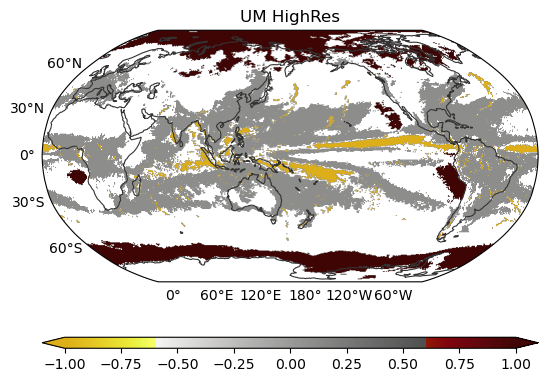

In [65]:
plot_data(um_regimes, vmin=-1, vmax=1, cmap=cmocean.cm.oxy_r, cbar_label='', plot_title='UM HighRes')

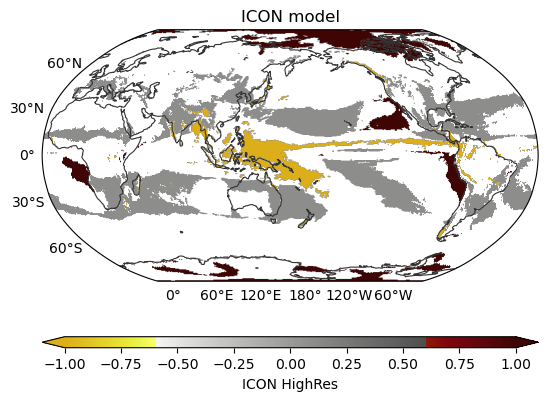

In [66]:
plot_data(icon_regimes, vmin=-1, vmax=1, cmap=cmocean.cm.oxy_r, cbar_label='ICON HighRes')

In [ ]:
import seaborn as sns

In [94]:
um_strat_ann = um_daily_loaded.sel(time = slice('2020-10-01', '2020-11-01')).where(um_regimes == 1)
um_modconv_ann = um_daily_loaded.sel(time = slice('2020-10-01', '2020-11-01')).where(um_regimes == 0.1)
um_strong_conv_ann = um_daily_loaded.sel(time = slice('2020-10-01', '2020-11-01')).where(um_regimes == -1)

um_regimes_rainfall = xr.merge([um_strat_ann.to_dataset(name='strat'), um_modconv_ann.to_dataset(name='mod'), um_strong_conv_ann.to_dataset(name='strong')])
um_regimes_rainfall

<xarray.Dataset> Size: 77MB
Dimensions:  (cell: 196608, time: 32)
Coordinates:
  * cell     (cell) int64 2MB 0 1 2 3 4 5 ... 196603 196604 196605 196606 196607
    crs      float64 8B nan
  * time     (time) datetime64[ns] 256B 2020-10-01T11:30:00 ... 2020-11-01T11...
Data variables:
    strat    (time, cell) float32 25MB nan nan nan nan nan ... nan nan nan nan
    mod      (time, cell) float32 25MB nan nan nan nan ... 0.0 0.001787 0.001776
    strong   (time, cell) float32 25MB nan nan nan nan nan ... nan nan nan nan

In [93]:
icon_strat_ann = icon_daily_loaded.sel(time = slice('2020-10-01', '2020-11-01')).where(icon_regimes == 1)
icon_modconv_ann = icon_daily_loaded.sel(time = slice('2020-10-01', '2020-11-01')).where(icon_regimes == 0.1)
icon_strong_conv_ann = icon_daily_loaded.sel(time = slice('2020-10-01', '2020-11-01')).where(icon_regimes == -1)

icon_regimes_rainfall = xr.merge([icon_strat_ann.to_dataset(name='strat'), icon_modconv_ann.to_dataset(name='mod'), icon_strong_conv_ann.to_dataset(name='strong')])
icon_regimes_rainfall

<xarray.Dataset> Size: 75MB
Dimensions:  (time: 32, cell: 196608)
Coordinates:
  * time     (time) datetime64[ns] 256B 2020-10-01 2020-10-02 ... 2020-11-01
Dimensions without coordinates: cell
Data variables:
    strat    (time, cell) float32 25MB nan nan nan nan nan ... nan nan nan nan
    mod      (time, cell) float32 25MB nan nan nan nan nan ... nan nan nan nan
    strong   (time, cell) float32 25MB nan nan nan nan nan ... nan nan nan nan

In [95]:
um_regimes_rainfall.to_netcdf('/scratch/nf33/hk25-ConvZones/um_regimes_rainfall_ann.nc')
icon_regimes_rainfall.to_netcdf('/scratch/nf33/hk25-ConvZones/icon_regimes_rainfall_ann.nc')

# um_regimes.to_netcdf('/scratch/nf33/hk25-ConvZones/um_regimes.nc')
# icon_regimes.to_netcdf('/scratch/nf33/hk25-ConvZones/icon_regimes.nc')

/scratch/nf33/as8561/tmp/ipykernel_2237601/2519453253.py:1: UserWarning: Times can't be serialized faithfully to int64 with requested units 'hours since 2020-01-20'. Serializing with units 'minutes since 2020-01-20' instead. Set encoding['dtype'] to floating point dtype to serialize with units 'hours since 2020-01-20'. Set encoding['units'] to 'minutes since 2020-01-20' to silence this warning .
  um_regimes_rainfall.to_netcdf('/scratch/nf33/hk25-ConvZones/um_regimes_rainfall_ann.nc')


In [28]:
um_regimes_rainfall = xr.open_dataset('/scratch/nf33/hk25-ConvZones/um_regimes_rainfall_ann.nc')
icon_regimes_rainfall = xr.open_dataset('/scratch/nf33/hk25-ConvZones/icon_regimes_rainfall_ann.nc')
era_regimes_rainfall = xr.open_dataset('/scratch/nf33/hk25-ConvZones/era_regimes_rainfall_ann.nc')*1000

In [97]:
um_regimes = xr.open_dataset('/scratch/nf33/hk25-ConvZones/um_regimes.nc')
icon_regimes = xr.open_dataset('/scratch/nf33/hk25-ConvZones/icon_regimes.nc')
# era_regimes = xr.open_dataset('/scratch/nf33/hk25-ConvZones/era_regimes.nc')

Text(0.5, 0, 'Precip')

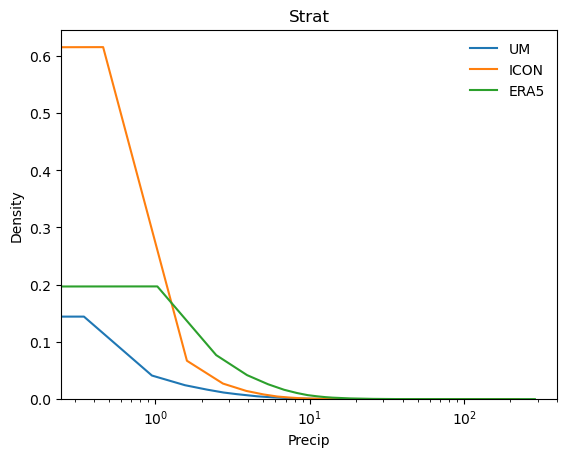

In [33]:
sns.kdeplot(um_regimes_rainfall.strat.values.ravel(), label='UM')
sns.kdeplot(icon_regimes_rainfall.strat.values.ravel(), label='ICON')
sns.kdeplot(era_regimes_rainfall.strat.values.ravel(), label='ERA5')
plt.gca().set_xscale('log')
plt.title('Strat')
plt.legend(frameon=False, fontsize=10)
plt.xlabel('Precip')

Text(0.5, 0, 'Precip')

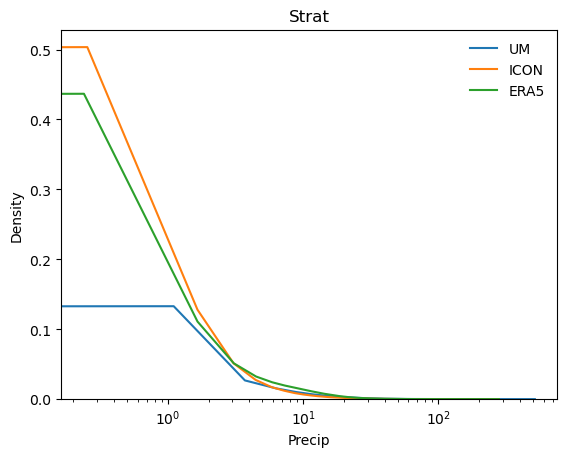

In [30]:
sns.kdeplot(um_regimes_rainfall.mod.values.ravel(), label='UM')
sns.kdeplot(icon_regimes_rainfall.mod.values.ravel(), label='ICON')
sns.kdeplot(era_regimes_rainfall.mod.values.ravel(), label='ERA5')
plt.gca().set_xscale('log')
plt.title('Moderate')
plt.legend(frameon=False, fontsize=10)
plt.xlabel('Precip')

Text(0.5, 0, 'Precip')

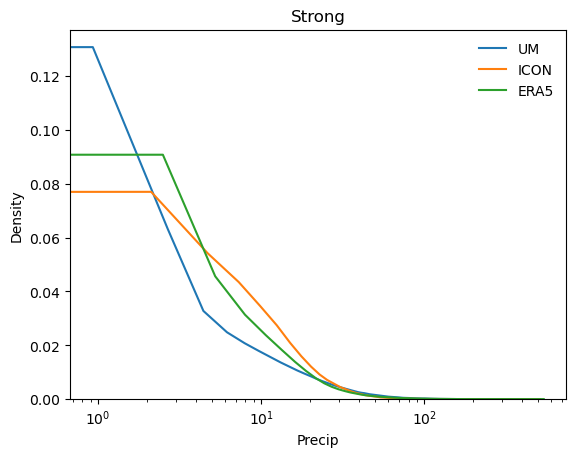

In [32]:
sns.kdeplot(um_regimes_rainfall.strong.values.ravel(), label='UM')
sns.kdeplot(icon_regimes_rainfall.strong.values.ravel(), label='ICON')
sns.kdeplot(era_regimes_rainfall.strong.values.ravel(), label='ERA5')
plt.gca().set_xscale('log')
plt.title('Strong')
plt.legend(frameon=False, fontsize=10)
plt.xlabel('Precip')

In [ ]:
sns.kdeplot(um_regimes_rainfall.strat.values.ravel())
sns.kdeplot(icon_regimes_rainfall.strat.values.ravel())
sns.kdeplot(era_regimes_rainfall.strong.values.ravel())
plt.gca().set_xscale('log')

In [20]:
era_regimes_rainfall.min('time')

<xarray.Dataset> Size: 24B
Dimensions:  ()
Data variables:
    strat    float64 8B 1.837
    mod      float64 8B 1.8
    strong   float64 8B 6.073

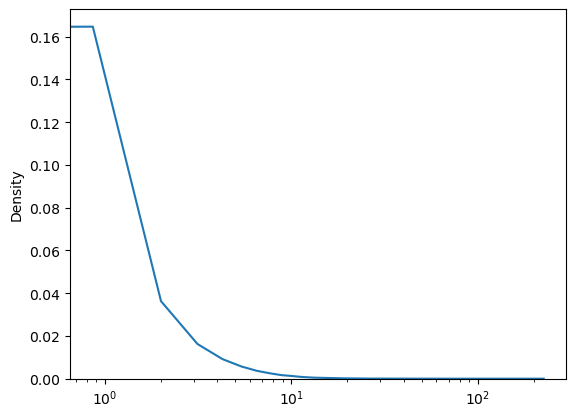

In [46]:
test = (icon_daily_loaded.where(icon_regimes["__xarray_dataarray_variable__"] == 1, drop=True).values.ravel())
sns.kdeplot(test[test > 0.0001])
plt.gca().set_xscale('log')

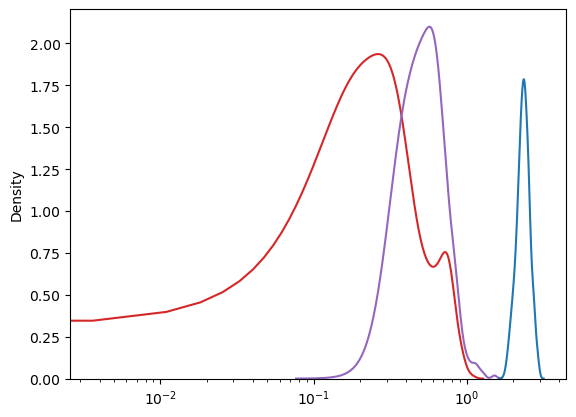

In [16]:
sns.kdeplot(um_regimes_rainfall.strat.where(um_regimes_rainfall.strat > 0.0001), color='tab:red')
sns.kdeplot(icon_regimes_rainfall.strat.where(icon_regimes_rainfall.strat > 0.0001), color='tab:purple')
sns.kdeplot(era_regimes_rainfall.strat, color='tab:blue')
plt.gca().set_xscale('log')
# plt.xticks([0.001, 0.01, 0.1, 1, 10, 100])

In [17]:
um_rlut_daily_loaded + um_rsut_daily_loaded

<xarray.DataArray 'rlut' (time: 366, cell: 196608)> Size: 288MB
array([[267.71045, 276.08447, 267.51144, ..., 137.55098, 150.32626,
        139.78023],
       [264.07462, 267.84622, 267.36615, ..., 183.30043, 191.55022,
        194.85083],
       [245.74255, 243.98944, 245.79572, ..., 193.932  , 185.69246,
        179.0185 ],
       ...,
       [289.38495, 289.72595, 290.35202, ..., 229.44756, 205.49287,
        235.31786],
       [291.06366, 291.39145, 291.929  , ..., 202.3749 , 153.00447,
        197.96997],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], shape=(366, 196608), dtype=float32)
Coordinates:
  * cell     (cell) int64 2MB 0 1 2 3 4 5 ... 196603 196604 196605 196606 196607
    crs      float64 8B nan
  * time     (time) datetime64[ns] 3kB 2020-03-01T11:30:00 ... 2021-03-01T11:...
Attributes:
    STASH:          [1, 2, 205]
    UM_name:        toa_outgoing_longwave_flux
    grid_mapping:   healpix_nested
    healpix_zoom:   7
    long_name:      toa_outgoing_longwave_flux
    source:         Data from Met Office Unified Model
    standard_name:  toa_outgoing_longwave_flux
    um_version:     13.5
    units:          W m-2